In [1]:
%matplotlib inline

from fastai import *
from fastai.vision import *

from IPython.display import display
PATH = os.path.abspath('../..')

seed = 12345

In [2]:
def evaluate_preds(Z_pred, Z_true, comment=''):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    *_, im = ax.hist2d(Z_true.flatten().numpy(), Z_pred.flatten().numpy(), bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', alpha=0.7)
    ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
    ax.set_aspect(aspect='equal')

    ax.text(8.25, 9.15, f'{comment}\n' f'RMSE={root_mean_squared_error(Z_pred, Z_true):.4f}', fontsize=16)

    ax.set_xlabel('Z_{\rm true}', fontsize=12)
    ax.set_ylabel('Z_{\rm pred}', fontsize=12)
    cb = fig.colorbar(im);
    cb.set_label('Number', fontsize=12)


# Load data

In [3]:
def get_data(df, tfms, bs=128, sz=128):
    data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )
    return data

In [4]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)

tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_zoom=1.15, p_lighting=0)

In [5]:
bs = 128
sz = 128

data = get_data(df, tfms=tfms, bs=bs)

# XResNet-34

In [6]:
learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


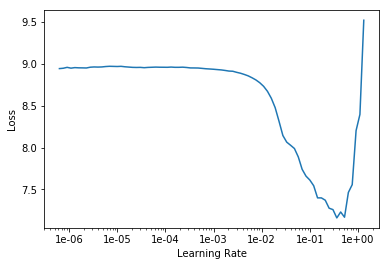

In [8]:
learn.recorder.plot()

`lr = 1e-2`, `bs=128`

In [17]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.593166,0.179759,01:24
1,0.409131,0.129961,01:20
2,0.352965,0.181764,01:22
3,0.319934,0.114075,01:21
4,0.307510,0.102676,01:22


## Train with 10% of data
e.g., use only 9500 images

10% of df, `lr = 1e-2`, `bs = 128`

In [29]:
data = get_data(df.sample(frac=0.1, random_state=seed), tfms=tfms, bs=128, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

In [30]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,time
0,8.418648,8.646830,00:12
1,5.137222,4.815183,00:09
2,2.339479,0.478570,00:09
3,1.261478,0.421289,00:09
4,0.867148,0.332512,00:09
5,0.692989,0.214508,00:11
6,0.613668,0.159837,00:09
7,0.560001,0.172983,00:09
8,0.513906,0.282714,00:09
9,0.480821,0.174988,00:09


`lr = 3e-2`, `bs = 256`

In [31]:
data = get_data(df.sample(frac=0.1, random_state=seed), tfms=tfms, bs=256, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(20, 3e-2)

epoch,train_loss,valid_loss,time
0,8.234156,6.455301,00:11
1,5.252488,1.304729,00:09
2,3.166047,0.797936,00:09
3,2.016753,0.639787,00:09
4,1.392079,0.318424,00:09
5,1.062450,0.579626,00:09
6,0.839866,0.185841,00:09
7,0.693201,0.459396,00:09
8,0.582749,0.147624,00:09
9,0.520134,0.175104,00:09


## 20 epochs with full data

In [32]:
data = get_data(df, tfms=tfms, bs=128, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,time
0,1.046194,0.322049,01:20
1,0.532946,0.246075,01:20
2,0.423018,0.188913,01:20
3,0.374451,0.432670,01:22
4,0.349049,0.128658,01:22
5,0.326813,0.184036,01:21
6,0.306473,0.175779,01:21
7,0.276006,0.154241,01:21
8,0.251592,0.107534,01:21
9,0.235808,0.124092,01:20


Validation loss has a lot of variance. Could that be due to our *not* using discriminative learning rates?

## XResNet34 -- 15 epochs with half data (and `bs=256`), non-discriminative `lr`

In [34]:
data = get_data(df.sample(frac=0.5, random_state=seed), tfms=tfms, bs=256, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,time
0,5.172954,1.031693,00:42
1,1.208194,0.266283,00:39
2,0.658810,0.242320,00:39
3,0.533576,0.488956,00:39
4,0.456486,0.127838,00:39
5,0.411035,0.282634,00:39
6,0.376590,0.187027,00:39
7,0.366524,0.194155,00:39
8,0.358250,0.287484,00:39
9,0.352134,0.118656,00:39


## ⭐ (0.098) XResNet34 -- 15 epochs with half data (and `bs=256`), *discriminative* `lr`

In [35]:
data = get_data(df.sample(frac=0.5, random_state=seed), tfms=tfms, bs=256, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,5.071529,0.936257,00:40
1,1.159842,0.303924,00:39
2,0.639543,0.170966,00:39
3,0.522946,0.257340,00:41
4,0.447329,0.207029,00:39
5,0.412170,0.251819,00:39
6,0.379026,0.151635,00:39
7,0.369643,0.135728,00:39
8,0.355945,0.109501,00:39
9,0.339513,0.130608,00:39


## Increase learning rate 
Apparently this doesn't work well for validation loss

In [36]:
data = get_data(df.sample(frac=0.5, random_state=seed), tfms=tfms, bs=256, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, slice(3e-4, 3e-2))

epoch,train_loss,valid_loss,time
0,2.282259,0.635200,00:40
1,0.698484,0.214960,00:39
2,0.515104,0.196384,00:46
3,0.450338,0.160609,00:46
4,0.422731,0.143626,00:39
5,0.401042,0.201808,00:40
6,0.376431,0.127623,01:03
7,0.368757,0.196744,01:11
8,0.331617,0.474018,01:20
9,0.307469,0.221367,01:08


## XResnet-34 -- Full data set, `bs=512`

In [40]:
data = get_data(df, tfms=tfms, bs=512, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,4.945884,1.061119,01:15
1,1.155876,0.258419,01:14
2,0.626298,0.172159,01:14
3,0.508607,0.193717,01:15
4,0.434558,0.129798,01:15
5,0.389586,0.147364,01:15
6,0.366202,0.108203,01:16
7,0.355724,0.120421,01:14
8,0.341724,0.127309,01:14
9,0.330199,0.107184,01:15


## XResnet-34 -- Full data set, `bs=1024`

In [41]:
data = get_data(df, tfms=tfms, bs=1024, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,7.924231,6.796147,01:24
1,3.093762,0.537716,01:16
2,1.247251,0.163268,01:16
3,0.719027,0.138862,01:17
4,0.555334,0.155074,01:16
5,0.486765,0.132462,01:16
6,0.453159,0.176283,01:18
7,0.419844,0.112388,01:17
8,0.398360,0.109524,01:17
9,0.381405,0.124877,01:16


## XResnet-34: Different adaptive learning rates (`bs=512`)

### ⭐ (0.093) `lr = slice(3e-4, 1e-2)`

In [42]:
data = get_data(df, tfms=tfms, bs=512, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, slice(3e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,4.852923,0.858273,01:15
1,1.103239,0.232471,01:14
2,0.609620,0.171964,01:15
3,0.501582,0.199005,01:14
4,0.425064,0.166357,01:16
5,0.388603,0.116307,01:16
6,0.361496,0.105644,01:15
7,0.352782,0.104587,01:15
8,0.339545,0.167192,01:15
9,0.331714,0.147713,01:14


### `lr = slice(1e-3, 1e-2)`

In [43]:
data = get_data(df, tfms=tfms, bs=512, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,4.889776,1.168345,01:15
1,1.148668,0.285024,01:15
2,0.637740,0.227643,01:14
3,0.523527,0.249922,01:15
4,0.440331,0.193348,01:15
5,0.390599,0.149371,01:14
6,0.364826,0.174558,01:14
7,0.349650,0.165275,01:15
8,0.339196,0.120984,01:16
9,0.328760,0.123918,01:16


### 40 epochs, `lr = slice(3e-4, 1e-2)`
Side note -- why does this do worse?

In [7]:
data = get_data(df, tfms=tfms, bs=512, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(40, slice(3e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,6.901511,5.120440,04:28
1,1.977453,0.443747,01:14
2,1.018707,0.231776,01:15
3,0.681121,0.191032,01:14
4,0.560786,0.194715,01:14
5,0.487639,0.141924,01:15
6,0.434097,0.162468,01:14
7,0.394015,0.117237,01:14
8,0.374212,0.153433,01:15
9,0.363978,0.218280,01:14


# ❌ XResNet-50

## 15 epochs -- half data set

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


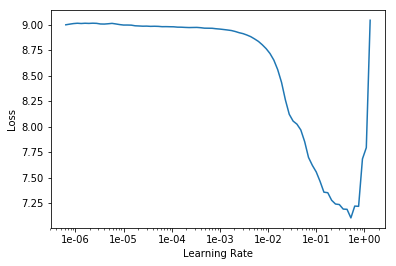

In [37]:
data = get_data(df.sample(frac=0.5, random_state=seed), tfms=tfms, bs=256, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet50, pretrained=False, loss_func=root_mean_squared_error)

learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(15, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,5.109355,0.944253,01:16
1,1.228884,0.359711,01:15
2,0.672588,0.306349,01:15
3,0.546224,0.187386,01:15
4,0.471019,0.185340,01:16
5,0.412261,0.149174,01:15
6,0.381779,0.148245,01:15
7,0.362902,0.159769,01:15
8,0.353633,0.123272,01:15
9,0.341208,0.128745,01:15


## 15 epochs -- Full data set

In [15]:
data = get_data(df, tfms=tfms, bs=128, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet50, pretrained=False, loss_func=root_mean_squared_error)

learn.fit_one_cycle(15, slice(1e-4, 1e-2), pct_start=0.2)

epoch,train_loss,valid_loss,time
0,0.754770,0.342186,02:36
1,0.449577,0.250829,02:35
2,0.382895,0.238317,02:35
3,0.347399,1.054270,02:35
4,0.314259,1.885268,02:36
5,0.289353,0.385213,02:35
6,0.258266,0.646249,02:36
7,0.241226,0.307975,02:36
8,0.227448,1.609812,02:35
9,0.214488,0.279305,02:36


Weird...

In [21]:
data = get_data(df, tfms=tfms, bs=128, sz=128)

learn = cnn_learner(data, base_arch=models.xresnet50, pretrained=False, loss_func=root_mean_squared_error)
learn.unfreeze()

learn.fit(1, 0.1)

epoch,train_loss,valid_loss,time
0,0.498841,7.844109,02:35


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


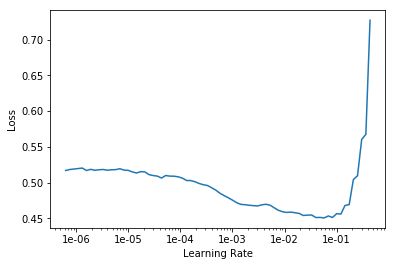

In [22]:
learn.lr_find()
learn.recorder.plot()

❌

In [ ]:
learn.fit_one_cycle(14, slice(1e-5, 1e-3))

# Modified XResNet-34

In [50]:
learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)

In [54]:
learn.model[1] = nn.Sequential(*learn.model[1][:4], nn.Linear(1024, 1).cuda())

In [55]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=1, bias=True)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


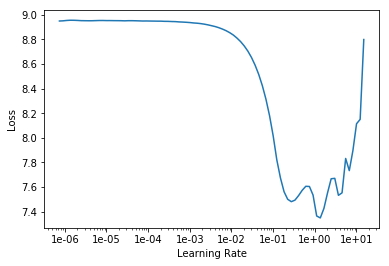

In [60]:
bs = 256
learn.data = get_data(df, tfms=tfms, bs=bs)

learn.lr_find(end_lr=50)
learn.recorder.plot()

## (0.092) Train 15 epochs with `bs=256` and  `lr=slice(1e-4, 1e-2)`

In [62]:
learn.fit_one_cycle(15, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,6.242628,5.304856,01:17
1,0.384379,0.140238,01:17
2,0.244857,0.114588,01:17
3,0.219467,0.107858,01:16
4,0.207432,0.105883,01:16
5,0.203875,0.102707,01:16
6,0.201856,0.102546,01:17
7,0.197515,0.100680,01:16
8,0.197206,0.102480,01:17
9,0.194940,0.094891,01:16


## ⭐ (0.090) Train 15 epochs with `bs=512` and  `lr=slice(5e-4, 5e-2)`

In [64]:
learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, loss_func=root_mean_squared_error)
learn.model[1] = nn.Sequential(*learn.model[1][:4], nn.Linear(1024, 1).cuda())

learn.data = get_data(df, tfms=tfms, bs=512)
learn.fit_one_cycle(15, slice(5e-4, 5e-2))

epoch,train_loss,valid_loss,time
0,3.471314,0.247089,01:19
1,0.410971,0.128912,01:15
2,0.226963,0.113862,01:14
3,0.216125,0.112625,01:15
4,0.213956,0.142832,01:15
5,0.207657,0.108046,01:15
6,0.206024,0.119870,01:15
7,0.201573,0.111622,01:15
8,0.201839,0.129493,01:15
9,0.197560,0.129175,01:14


## (❌) Train 15 epochs with `bs=64` and  `lr=slice(1e-4, 1e-2)`

## (❌) Train 15 epochs with `bs=1024` and  `lr=slice(1e-3, 1e-1)`

In [18]:
nf = 1024
nc = 1

head = create_head(nf, nc, lin_ftrs=[], ps=[0.1], concat_pool=True, bn_final=False)
learn = cnn_learner(data, base_arch=models.xresnet34, pretrained=False, custom_head=head, loss_func=root_mean_squared_error)


In [ ]:
learn.data = get_data(df, tfms=tfms, bs=1024)
learn.fit_one_cycle(15, slice(1e-3, 1e-1))